## Explain model comparison toy example

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import time 
from tqdm import tqdm

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

from delfi.distribution.mixture import MoG
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 19,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 21,
                      'xtick.labelsize': 19,
                      'ytick.labelsize': 19,
             'figure.figsize' : (18, 5), 
             'axes.titlepad': -10}

mpl.rcParams.update(mpl_params)

## Set up Poisson and Negative Binomial model

In [3]:
seed = 2
rng = np.random.RandomState(seed=seed)
time_stamp = time.strftime('%Y%m%d%H%M_')
figure_folder = '../figures/'

In [4]:
sample_size = 5
ntrain = 50000
ntest = 500

k2 = 2.
theta2 = 1.0

k3 = 2.
theta3 = 2. 

# then the scale of the Gamma prior for the Poisson is given by
theta1 = 2.0
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1)


model_poisson = PoissonModel(sample_size=sample_size, seed=seed, n_workers=2)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed, n_workers=2)

4.0


## Generate parameters from the priors 

In [5]:
# from Gamma prior for Poisson 
prior_lam = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

n = ntrain + ntest
params_poi = prior_lam.rvs(size=int(n / 2))
params_nb = np.vstack((prior_k.rvs(size=int(n / 2)), 
                       prior_theta.rvs(size=int(n / 2)))).T

## Generate data from models and calculate summary stats, prepare test data 

In [6]:
data_poi = model_poisson.gen(params_poi)
data_nb = model_nb.gen(params_nb)

In [7]:
# shuffle and set up model index target vector 
x_all = np.vstack((data_poi, data_nb))

# define model indices
m_all = np.hstack((np.zeros(data_poi.shape[0]), np.ones(data_nb.shape[0]))).squeeze().astype(int)

# get shuffled indices 
shuffle_indices = np.arange(n)
np.random.shuffle(shuffle_indices)

# shuffle the data 
x_all = x_all[shuffle_indices, ]
m_all = m_all[shuffle_indices].tolist()

x, xtest = x_all[:ntrain, :], x_all[ntrain:, :]
m, mtest = m_all[:ntrain], m_all[ntrain:]

# calculate summary stats
sx = calculate_stats_toy_examples(x)
sx_test = calculate_stats_toy_examples(xtest)
# use training norm to normalize test data 
sx_zt, training_norm = normalize(sx)
sx_test_zt, training_norm = normalize(sx_test, training_norm)

## Set up the NN and train it 

In [8]:
model = ClassificationMDN(n_input=2, n_hidden_units=10, n_hidden_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 10
n_minibatch = int(ntrain / 100)

training: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


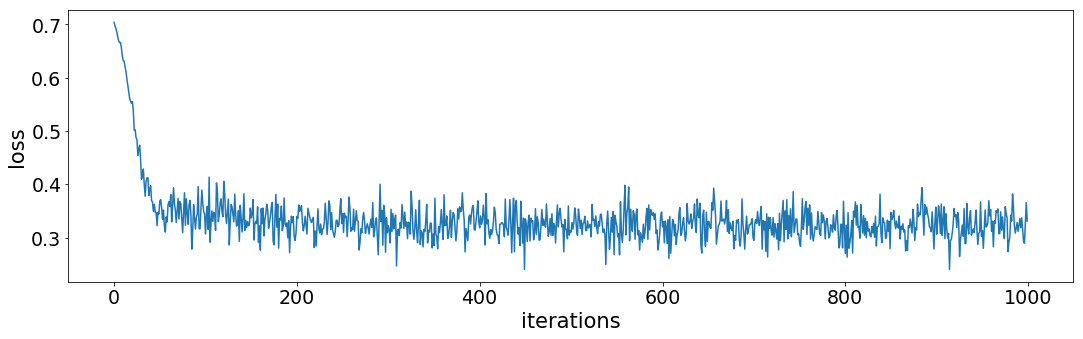

In [9]:
# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Visualize network 

In [10]:
ppoi_exact = []
with tqdm.tqdm(total=len(mtest), desc='Calculate evidences for test samples', ncols=110) as pbar: 
    for xi in xtest: 
        nb_logevi = calculate_nb_evidence(xi, k2, theta2, k3, theta3, log=True)
        poi_logevi = poisson_evidence(xi, k=k1, theta=theta1, log=True)
        ppoi_exact.append(calculate_pprob_from_evidences(np.exp(poi_logevi), np.exp(nb_logevi)))
        pbar.update()

Calculate evidences for test samples:  77%|█████████████████████████▍       | 386/500 [03:07<00:57,  1.99it/s]../../model_comparison/utils.py:662: RuntimeWarning: divide by zero encountered in log
  value = np.log(nbinom_pmf(x, r, p)).sum() + np.log(pr) + np.log(pp)
Calculate evidences for test samples: 100%|█████████████████████████████████| 500/500 [04:04<00:00,  3.38it/s]


In [11]:
ms, vs = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 100, 100))
# stack values to evaluate as vector in the model 
sx_vis = np.vstack((ms.flatten(), vs.flatten())).T
# normalize 
sx_vis, training_norm = normalize(sx_vis, training_norm)


# predict probs 
ppoi_vec = model.predict(sx_vis)
# take poisson posterior prob and reshape to grid dimensions
ppoi_vismat = ppoi_vec[:, 0].reshape(ms.shape[0], vs.shape[0])

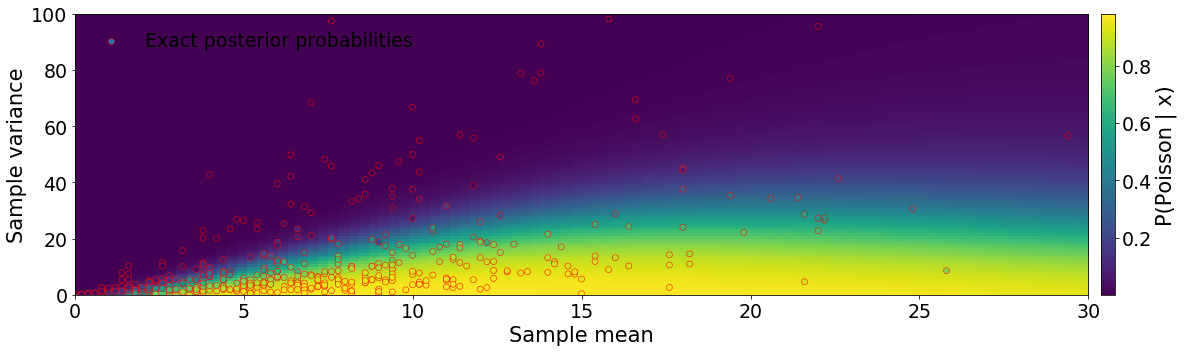

In [12]:
plt.figure(figsize=(18, 5))
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.viridis

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, 
            norm=cnorm, edgecolors='r', linewidths=.5)
plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.colorbar(label='P(Poisson | x)', pad=0.01)
plt.legend(['Exact posterior probabilities'])
plt.tight_layout();

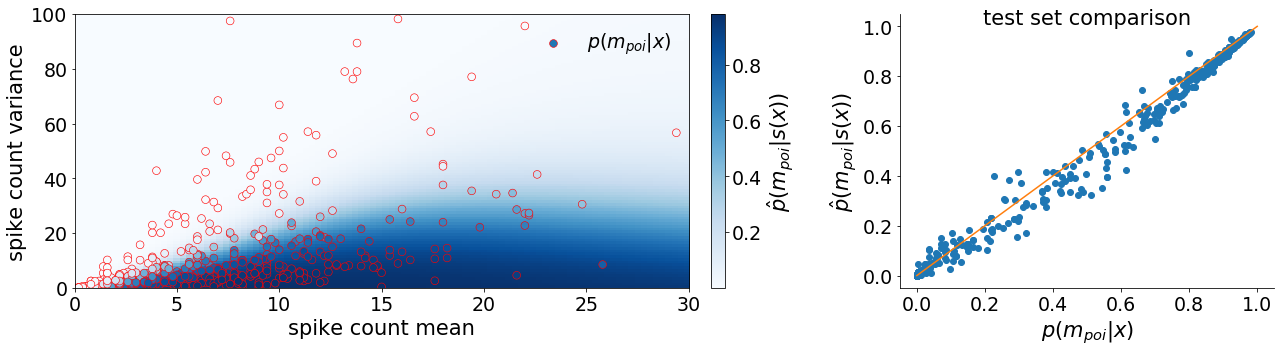

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw=dict(width_ratios=[2, 1]))

plt.sca(ax[0])
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.Blues

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, 
            norm=cnorm, edgecolors='red', linewidths=.6, s=60)
plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('spike count mean')
plt.ylabel('spike count variance')
plt.colorbar(label=r'$\hat{p}(m_{poi} | s(x))$', pad=0.03)
plt.legend([r'$p(m_{poi} | x)$'])

# plot all test samples
plt.sca(ax[1])
plt.plot(ppoi_exact, model.predict(sx_test_zt)[:, 0], 'o')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.ylabel(r'$\hat{p}(m_{poi} | s(x))$')
plt.xlabel(r'$p(m_{poi} | x)$')
plt.title('test set comparison')

# Remove top and right borders 
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.tight_layout()

In [14]:
fullpath = os.path.expanduser('~') + '/LRZBOX/PhD/writing/CogComp2018/poster/figs/fig3/fig3_raw.pdf'
fig.savefig(fullpath, dpi=300)

## Observe Poisson data and predict underlying model 

In [15]:
# generate a single sample of Poisson data, with lambda at the mean of the model prior 
true_lambda = rng.gamma(shape=k1, scale=theta1)
x_obs = rng.poisson(lam=true_lambda, size=sample_size)
# calculate stats 
sx_obs = calculate_stats_toy_examples(x_obs)
# normalize using training data normalization 
sx_obs_zt, training_norm = normalize(sx_obs, training_norm)

In [16]:
# predict 
p_vec = model.predict(sx_obs_zt).squeeze()
# calculate exact evidence 
nb_evidence = calculate_nb_evidence(x_obs, k2, theta2, k3, theta3, log=True)
poi_evidence = poisson_evidence(x_obs, k=k1, theta=theta1, log=True)
ppoi_ana = calculate_pprob_from_evidences(np.exp(poi_evidence), np.exp(nb_evidence))

print(r'predicted P(poisson | data) = {:.2f}'.format(p_vec[0]))
print(r'exact P(poisson | data) = {:.2f}'.format(ppoi_ana))

predicted P(poisson | data) = 0.94
exact P(poisson | data) = 0.95


In [17]:
dict_modelpost = dict(seed=seed, trainer=trainer, model_models=model,
                       x=x, m=m, xtest=xtest, mtest=mtest, 
                       sx=sx, sx_test=sx_test, 
                       training_norm=training_norm, param_poi=params_poi, params_nb=params_nb, 
                       theta1=theta1, theta2=theta2, theta3=theta3, 
                       k1=k1, k2=k2, k3=k3, 
                       sample_size=sample_size, n_samples=ntrain, 
                       ppoi_exact=ppoi_exact)

## Given the predicted underlying model we can learn the posterior of its parameters

In [18]:
# define a network to approximate the posterior with a MoG 
model_params_mdn = UnivariateMogMDN(ndim_input=2, n_hidden=10, n_components=2)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [19]:
# calculate stats for poisson model 
sx_poi = calculate_stats_toy_examples(data_poi)

# normalize data 
sx_poi_zt, data_norm = normalize(sx_poi)

# normalize prior params 
params_poi_zt, prior_norm = normalize(params_poi)

In [20]:
loss_trace = trainer.train(sx_poi_zt, params_poi_zt, n_epochs=50, n_minibatch=int(n_minibatch))

training: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


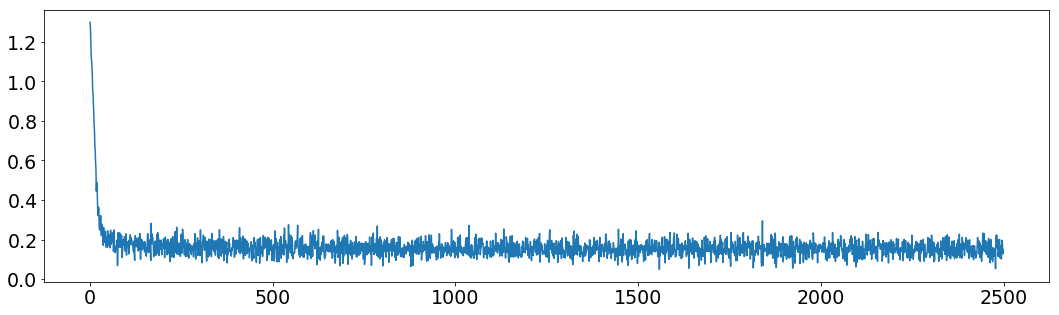

In [21]:
plt.plot(loss_trace);

In [22]:
n_thetas = 1000
thetas_poisson = np.linspace(true_lambda - 10, true_lambda + 10, n_thetas)

In [23]:
# normalize the observed data 
sx_obs_zt, data_norm = normalize(sx_obs, data_norm)

## Get delfi MoG for plotting and inverse z transform 

In [24]:
# generate a single sample of Poisson data, with lambda at the mean of the model prior 
true_lambda = rng.gamma(shape=k1, scale=theta1)
x_obs = rng.poisson(lam=true_lambda, size=sample_size)
# calculate stats 
sx_obs = calculate_stats_toy_examples(x_obs)
# normalize using training data normalization 
sx_obs_zt, _ = normalize(sx_obs, data_norm)

In [25]:
(out_mu, out_sigma, out_alpha) = model_params_mdn(Variable(torch.Tensor(sx_obs_zt)))

# convert to dd format 
a = out_alpha.data.numpy().squeeze().tolist()
ms = [[m] for m in out_mu.data.numpy().squeeze().tolist()]
Ss = [[[s**2]] for s in out_sigma.data.numpy().squeeze().tolist()]

# set up dd MoG object 
mog_posterior_delfi_zt = MoG(a=a, ms=ms, Ss=Ss)

In [26]:
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])
posterior_pdvalues = mog_posterior_delfi.eval(x=thetas_poisson.reshape(1000, -1), log=False)

## Get true posterior

In [27]:
# get analytical gamma posterior 
k_post = k1 + np.sum(x_obs)

# use the posterior given the summary stats, not the data vector 
scale_post = 1. / (sample_size + theta1**-1)

# somehow we have to scale with N again, why? because the scale is changed due to s(x) by 1/N  
true_post_poisson = gamma.pdf(x=thetas_poisson, a=k_post, scale=scale_post)

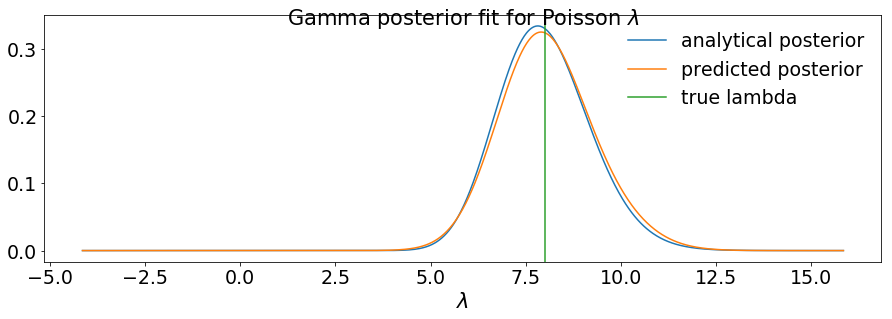

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title(r'Gamma posterior fit for Poisson $\lambda$')
# plt.plot(thetas_poisson, gamma_prior.pdf(thetas_poisson), label='prior')
plt.plot(thetas_poisson, true_post_poisson, label='analytical posterior')
plt.plot(thetas_poisson, posterior_pdvalues, label='predicted posterior')
plt.axvline(x=k1 * theta1, color="C2", label='true lambda')
plt.legend()
plt.xlabel(r'$\lambda$');

## Quantile check

In [29]:
# generate test data 
ntest = 1000
params_test = prior_lam.rvs(size=ntest)
params_test_zt, _ = normalize(params_test, prior_norm)

x_test = model_poisson.gen(params_test)
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, data_norm)

In [30]:
# qis = np.zeros(ntest)
nbreak = ntest
qis = np.zeros(nbreak)
# for every test sample 
for ii, (thetao_i, sxo_i) in enumerate(zip(params_test_zt, sx_test_zt)): 
    
    # predict the posterior
    posterior = model_params_mdn.predict(sxo_i.reshape(1, -1))
    
    # get quantile of theta_o
    qis[ii] = posterior.get_quantile(thetao_i)
    if ii==nbreak-1: 
        break

In [31]:
d_param_post = dict(seed=seed, trainer=trainer, params_mdn=model_params_mdn, x=data_poi, y=params_poi, sx=sx_poi, 
               x_test=x_test, sx_test=sx_test, y_test=params_test, training_norm=data_norm, prior_norm=prior_norm, 
               theta1=theta1, theta2=theta2, theta3=theta3, k1=k1, k2=k2, k3=k3, 
               sample_size=sample_size, n_samples=ntrain)

In [32]:
fn = os.path.join('../data/', time_stamp + '_poisson_posterior_trained_N{}M{}_k{}.p'.format(ntrain, sample_size, 
                                                                                         int(k2)))

with open(fn, 'wb') as outfile: 
    pickle.dump(dict(d_model_post=dict_modelpost, d_param_post=d_param_post), outfile, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
fn

'../data/201812141735__poisson_posterior_trained_N50000M5_k2.p'

## Test of uniformity

In [31]:
scipy.stats.kstest(qis, cdf='uniform')

KstestResult(statistic=0.03376621783888967, pvalue=0.19993659316247858)

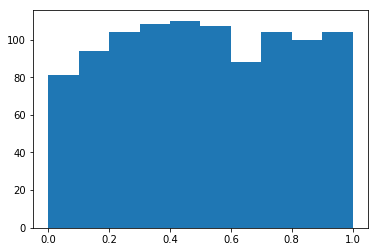

In [32]:
n, bins, patch = plt.hist(qis, bins=10);

## We can also observe NB data, predict idx and learn the posterior
The NB posterior is 2D, one dimension for $k$ and once for $\theta$. 

In [33]:
# define a network to approximate the posterior with a MoG 
model_params_mdn = MultivariateMogMDN(ndim_input=2, ndim_output=2, n_hidden_units=10, 
                                      n_hidden_layers=2, n_components=2)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [34]:
# calculate stats for poisson model 
sx_nb = calculate_stats_toy_examples(data_nb)

# normalize data 
sx_nb_zt, data_norm = normalize(sx_nb)

# normalize prior params 
params_nb_zt, prior_norm = normalize(params_nb)

In [35]:
loss_trace = trainer.train(sx_nb_zt, params_nb_zt, n_epochs=200, n_minibatch=200)

training:  15%|█▌        | 30/200 [00:34<03:16,  1.15s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(loss_trace)

## Observe NB data 

In [ ]:
thetao = [[prior_k.rvs(), prior_theta.rvs()]]
xo = model_nb.gen(thetao)
sxo = calculate_stats_toy_examples(xo)
sxo_zt, _ = normalize(sxo, data_norm)
thetao_zt, _ = normalize(thetao, prior_norm)

In [ ]:
# predict posterior and transform to absolut range
phat = model_params_mdn.predict(sxo_zt)

In [ ]:
print(phat.mean, thetao_zt)

## Find a way to compare to the exact posterior

## Quantile check 

ToDo: 
    - multivariate quantile check DONE 
    - derive exact posterior 


In [ ]:
# generate test data 
ntest = 1000
params_test = np.vstack((prior_k.rvs(ntest), prior_theta.rvs(ntest))).T
params_test_zt, _ = normalize(params_test, prior_norm)

x_test = model_nb.gen(params_test)
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, data_norm)

In [ ]:
qis = np.zeros(ntest)
# for every test sample 
for ii, (thetao_i, sxo_i) in enumerate(zip(params_test_zt, sx_test_zt)): 
    
    # predict the posterior
    posterior = model_params_mdn.predict(sxo_i.reshape(1, -1))
    
    # get quantile of theta_o
    qis[ii] = posterior.get_quantile(thetao_i.reshape(1, -1))


In [ ]:
plt.hist(qis, bins='auto');

either the fit is very bad or the quantile calculation is wrong. double check by deriving the exact posterior and compute it numerically. then one can see the goodness of the fit in terms of dkl, means and std. 